# All you need is love... and a good chemical affinity🧪❤️

In [52]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset, get_dataset2
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils
from sklearn.cluster import KMeans,SpectralClustering
from scikit_posthocs import posthoc_dunn
import os
import zipfile

#Imports to get rid of warnings
import warnings
from rdkit import RDLogger
import plotly.express as px
import scipy.stats as stats
RDLogger.DisableLog('rdApp.warning')

#Set a palette for all plots
sns.set_palette('Paired')


First of all, we can import the dataset with the ad-hoc function `get_dataset_complete`.

In [11]:
#Read the complete BindingDB dataset
df = get_dataset2()

#Plot the number of rows and columns in the dataset
print(f'BindingDB dataset rows: {df.shape[0]}')
print(f'BindingDB dataset columns: {df.shape[1]}')

BindingDB dataset rows: 2913040
BindingDB dataset columns: 194


The `BindingDB` dataset contains measured binding affinities between ligands (drugs) and protein targets in several organisms. Many affinity metrics are available, in particular $IC50$, $K_i$, $EC50$ and $K_d$, both from scientific literature and registered patents. Many experimental parameters are also available, such as the temperature and the pH at which the measurements were conducted. The `Target Source Organism According to Curator or DataSource` column contains the species (or type of living organism) that produces the target protein, being it an enzyme, receptor, etc. (this is instead contained in the `Target Name`) column. About the ligand, many representation formats are available, such as its SMILES string. For both the ligand and the target, IDs for locating them in different datasets (DrugBank, SwissProt) are available.  
To get a first intuition of which are such targets, we can visualize the target distirbution:

## Target organisms distribution

In [ ]:
evaluation_utils.plot_target_organism_distribution_plotly(df)

We clearly observe that the most targeted organism is the human, indicating that many diseases are associated with human endogenous proteins. However, there is also a significant focus on other mammals, such as mice (`Mus musculus`) and rats (`Rattus`, `Rattus norvegicus`), and also a big spot is reserved for `Human immunodeficiency virus 1` (HIV1), reflecting the continued effort to address the critical global health challenge that it presents.  
Below we also plot the frequencies of the 20 most targeted organisms, to quantify this distribution:

In [19]:
most_targeted_organisms = df['Target Source Organism According to Curator or DataSource'].value_counts()[:20].reset_index()
most_targeted_organisms

,Target Source Organism According to Curator or DataSource,count
0,Homo sapiens,1541006
1,Rattus norvegicus,109758
2,Mus musculus,49854
3,Rattus,33713
4,Human immunodeficiency virus 1,21780
5,Bos taurus,17618
6,Electrophorus electricus,7921
7,Cavia porcellus,7639
8,Cavia cutleri,6540
9,Escherichia coli,5651


For our analysis, from the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs associated with `Human Immunodeficiency Virus 1 (HIV 1)`. Below we create it and plot its length:

In [27]:
hiv = df[df['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
print("Length of HIV dataset:", len(hiv))

Length of HIV dataset: 21780


In the dataset, four affinity metric are available:

1. **$K_i$ (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **$IC50$ (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **$K_d$ (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **$EC50$ (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between $K_i$ and $IC50$, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided. Below is a plot comparing the frequency of the metrics' presence and their relative overlapping:

In [ ]:
evaluation_utils.plot_metric_availability_with_plotly(hiv)
evaluation_utils.plot_overlap_matrix_with_plotly(hiv)

,Metric 2,Metric 1,Overlap (%)
0,Ki (nM),Ki (nM),100.000000
1,IC50 (nM),Ki (nM),1.037657
2,Kd (nM),Ki (nM),1.770715
3,EC50 (nM),Ki (nM),1.144383
4,Ki (nM),IC50 (nM),1.037657
5,IC50 (nM),IC50 (nM),100.000000
6,Kd (nM),IC50 (nM),0.000000
7,EC50 (nM),IC50 (nM),0.188857
8,Ki (nM),Kd (nM),1.770715
9,IC50 (nM),Kd (nM),0.000000


We observe that $IC50$ is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with $IC50$ for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.  
  
  
We also plot below the number of rows left after this operation:



In [35]:
hiv = data_utils.select_metric(hiv, 'IC50 (nM)')
hiv = data_utils.clean_na_columns(hiv)
print(f'Rows of STD dataset where IC50 is given: {hiv.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {hiv.shape[1]}')

Rows of STD dataset where IC50 is given: 13754
Columns of STD dataset where nan rows are less than 50% of the total: 27


# Focus on target proteins
Having selected the target organism, the Human Immunodeficiency Virus, we want now to study how we actually target it. We first focus on the target proteins in this virus:

In [38]:
evaluation_utils.plot_most_targeted_proteins_plotly(hiv)

We observe that many targets marked as different are just mutations or different sites of the same protein.  
To achieve a broader understanding, we decided to condense mutated proteins into the same category, and to not consider different sites on the same protein as different targets. Moreover, many proteins are just different conventional names for the same protein, and we accounted also for that. For instance, Reverse Transcriptase and Reverse Transcriptase/RNaseH were grouped under Reverse Transcriptase. This approach provides a generalized view while maintaining biological relevance.

In [ ]:
hiv_condensed = evaluation_utils.group_similar_targets(hiv)

In [ ]:
evaluation_utils.plot_most_targeted_proteins_plotly(hiv_condensed)

## Targeted HIV-1 Proteins

We clearly see that the most targeted proteins in HIV-1 are:

- **Reverse transcriptase**
- **Gag-Pol polyprotein**
- **Integrase**

Below is a brief description of these:

#### Reverse Transcriptase
Reverse transcriptase is an enzyme that plays a critical role in the HIV lifecycle by converting the virus's single-stranded RNA genome into double-stranded DNA once the virus enters a host cell. This conversion allows the viral DNA to integrate into the host’s genome, a necessary step for HIV replication.

Due to its essential function, reverse transcriptase is a major target for antiretroviral drugs. Two primary classes of inhibitors target this enzyme:
- **Nucleoside Reverse Transcriptase Inhibitors (NRTIs)**: These drugs mimic DNA building blocks, causing premature termination of the DNA chain and stopping HIV replication.
- **Non-Nucleoside Reverse Transcriptase Inhibitors (NNRTIs)**: These drugs bind directly to reverse transcriptase, blocking its activity by altering the enzyme's shape.

#### Gag-Pol Polyprotein
The Gag-Pol polyprotein is a precursor protein produced from the HIV genome that contains multiple essential viral components, including reverse transcriptase, protease, and integrase. During viral maturation, the Gag-Pol polyprotein is cleaved into its functional proteins by the **protease** enzyme, allowing the formation of mature, infectious viral particles.

**Protease inhibitors** are a class of antiretroviral drugs that specifically target the protease enzyme within the Gag-Pol polyprotein. By inhibiting protease, these drugs prevent the cleavage of Gag-Pol, halting the maturation of new viral particles and rendering them non-infectious.

#### Integrase
Integrase is another enzyme within the Gag-Pol polyprotein that facilitates the integration of HIV's DNA into the host cell's genome. This integration is a crucial step in establishing a permanent infection.   
**Integrase inhibitors** target this enzyme, blocking the integration process and thus preventing HIV from establishing a foothold within host cells.



To assess which protein targets are associated with the highest inhibitor affinity, we present the boxplots of the $IC50$ values for the most targeted HIV-1 proteins:

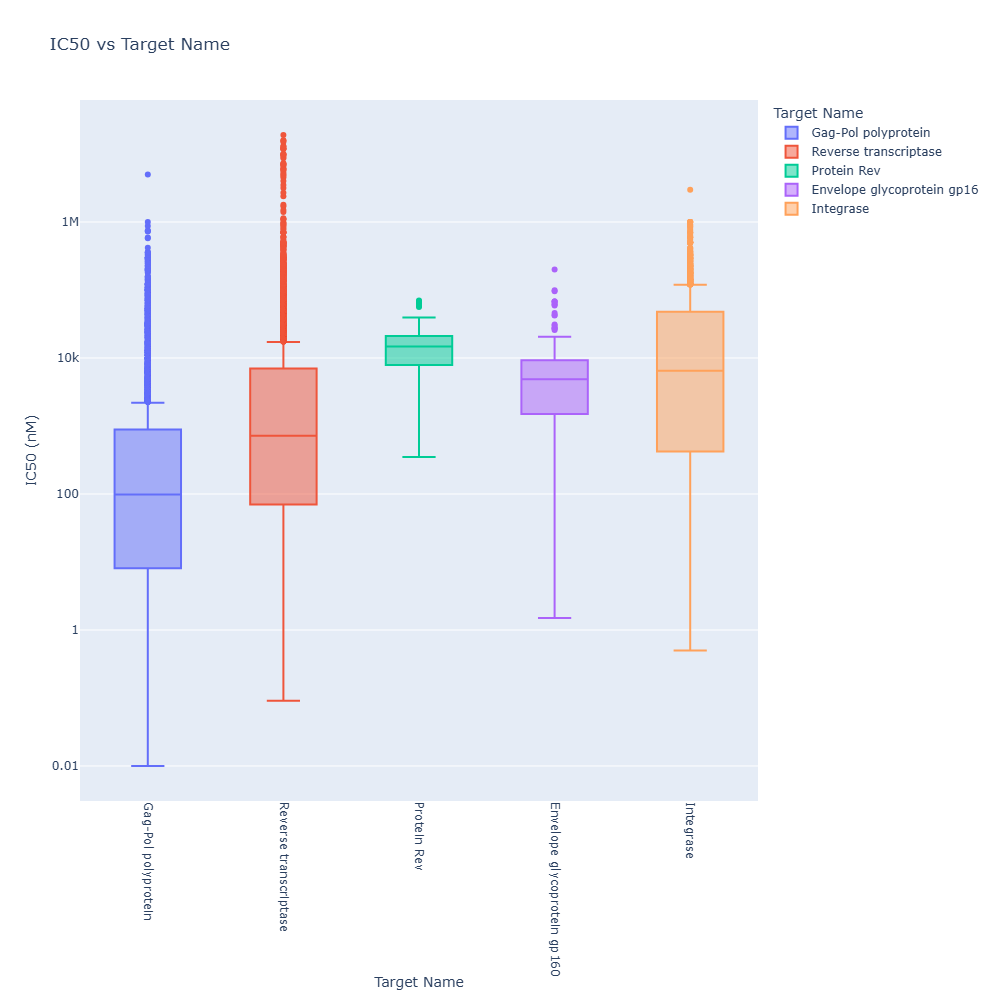

In [47]:
evaluation_utils.create_ic50_boxplot_plotly(hiv_condensed)

#### Check for differences in distribution

To statistically compare the IC50 values for the targeted proteins (`Gag-Pol polyprotein`, `Reverse transcriptase`, `Protein Rev`, and `Envelope glycoprotein gp160`), we initially considered using **ANOVA (Analysis of Variance)**.

ANOVA is used to test whether there are significant differences in the means of three or more groups. It operates under the following hypotheses:
- H0 (Null Hypothesis): The means of all groups are equal.
- H1 (Alternative Hypothesis): At least one group mean is different.

ANOVA assumes that the data in each group are normally distributed. To validate this assumption, we performed the *Kolmogorov-Smirnov* test for normality, as the dataset was too large to use the *Shapiro-Wilk* test. The *Kolmogorov-Smirnov* test evaluates whether the data conforms to a specified distribution, the normal in our case. The hypotheses for the test are:

- H0: The data follows a normal distribution.
- H1: The data does not follow a normal distribution.

In [47]:
for target in hiv_condensed['Target Name'].unique():
    data = hiv_condensed[hiv_condensed['Target Name'] == target]['Log_IC50']
    ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"{target}: KS-Test Statistic = {ks_stat}, p-value = {ks_p}")

Gag-Pol polyprotein: KS-Test Statistic = 0.022772650435381014, p-value = 0.008943406243163688
Reverse transcriptase: KS-Test Statistic = 0.03629943150140025, p-value = 2.5860021051731565e-07
Protein Rev: KS-Test Statistic = 0.13188194484492505, p-value = 0.18400160343832972
Envelope glycoprotein gp160: KS-Test Statistic = 0.11877823817476746, p-value = 0.0064662441313943966
Integrase: KS-Test Statistic = 0.09064312628998739, p-value = 9.603906015932796e-17


As shown in the results of the *Kolmogorov-Smirnov* test, not all distributions are normally distributed. Therefore, we will the *Kruskal-Wallis* test as a non-parametric alternative to ANOVA, and start considering the medians of the logarithmic $IC50$ instead of the means, since this metric is more robust to skewed distributions.

The *Kruskal-Wallis* Test is a rank-based test that does not assume normality. It evaluates whether the medians of two or more groups are significantly different. The hypotheses for the *Kruskal-Wallis* test are:

- H0 (Null Hypothesis): The distributions (and medians) of all groups are equal.
- H1 (Alternative Hypothesis): At least one group has a different median.

In [56]:
# Organize data by groups
groups = [hiv_condensed[hiv_condensed['Target Name'] == name]['Log_IC50'] for name in hiv_condensed['Target Name'].unique()]

# Kruskal-Wallis Test
kruskal_stat, kruskal_p = stats.kruskal(*groups)
print(f"Kruskal-Wallis Test: H-statistic = {kruskal_stat}, p-value = {kruskal_p}")

if kruskal_p < 0.05:
    print("Significant differences found between groups.")
else:
    print("No significant differences between groups.")


Kruskal-Wallis Test: H-statistic = 2054.892714121525, p-value = 0.0
Significant differences found between groups.


In [57]:
# Calculate medians for each target
medians = hiv_condensed.groupby('Target Name')['Log_IC50'].median()
print(medians)


Target Name
Envelope glycoprotein gp160    3.687484
Gag-Pol polyprotein            1.991226
Integrase                      3.812913
Protein Rev                    4.170055
Reverse transcriptase          2.857935
Name: Log_IC50, dtype: float64


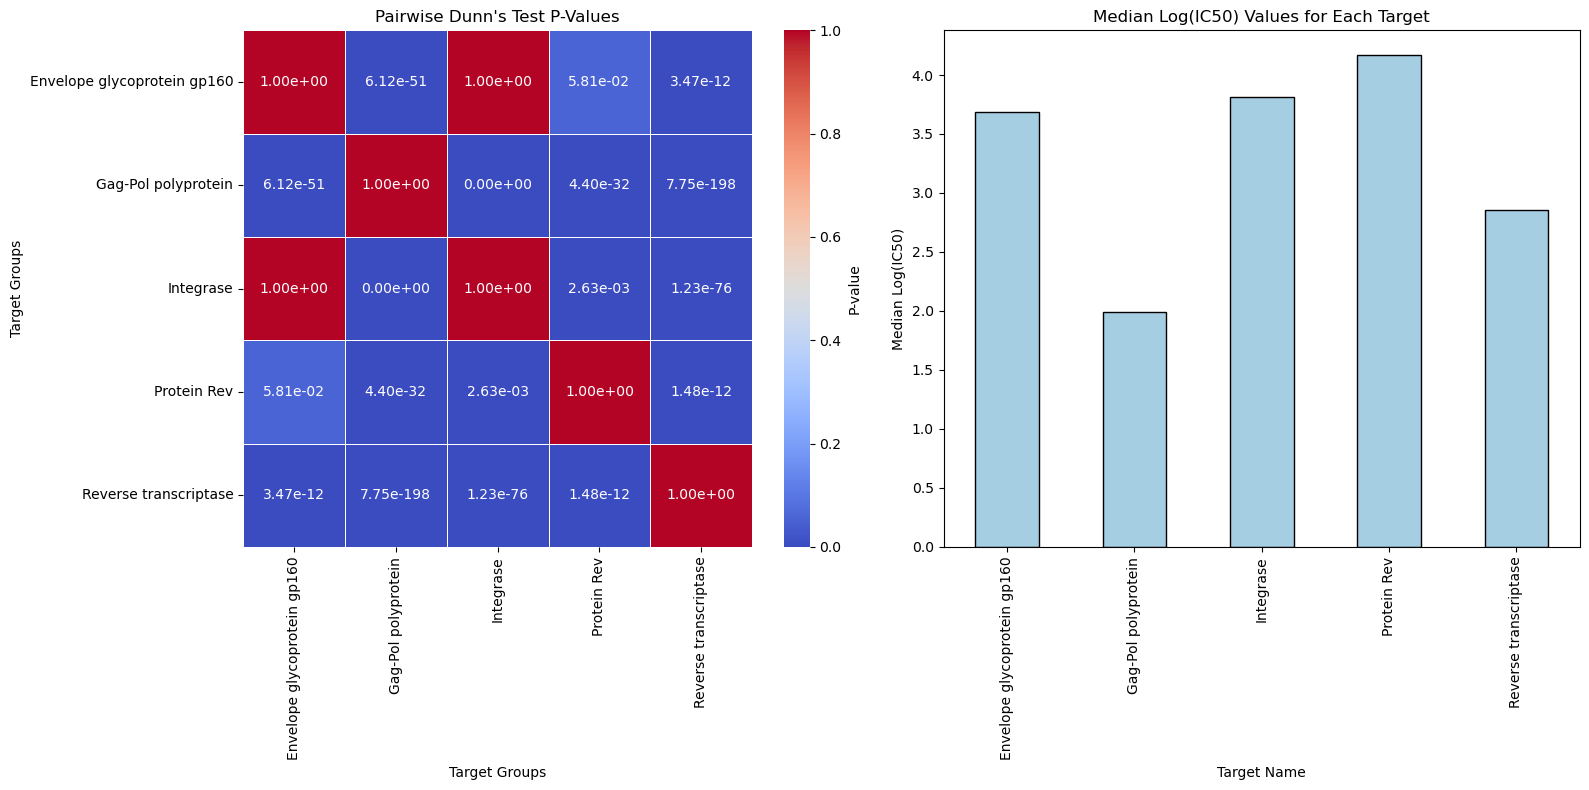

In [64]:
posthoc = posthoc_dunn(
    hiv_condensed, 
    val_col='Log_IC50', 
    group_col='Target Name', 
    p_adjust='bonferroni'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for Dunn's test p-values
sns.heatmap(
    posthoc, 
    annot=True, 
    fmt=".2e", 
    cmap="coolwarm", 
    cbar_kws={'label': 'P-value'}, 
    linewidths=0.5, 
    ax=axes[0]
)
axes[0].set_title("Pairwise Dunn's Test P-Values")
axes[0].set_xlabel("Target Groups")
axes[0].set_ylabel("Target Groups")

# Bar plot for medians
medians.plot(kind='bar', edgecolor = 'black', ax=axes[1])
axes[1].set_title("Median Log(IC50) Values for Each Target")
axes[1].set_xlabel("Target Name")
axes[1].set_ylabel("Median Log(IC50)")
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


From the results of the pairwise Dunn's test (left plot), we observe that between the Gag-Pol polyprotein and other targets the p-values are extremely small, with the largest one being `4.40e-32`. This implies that, at the standard significance level of 0.05, Gag-Pol polyprotein median logarithmic $IC50$ is **significantly different** from the other groups. By looking at the median $IC50$ values for the groups (right plot), we observe that Gag-Pol polyprotein's one is **lower** than those for other groups.  

These results suggest that Gag-Pol polyprotein has a **significantly better binding affinity** than other targets from HIV-1, indicating that it may be the most sensitive target in the figth against the virus. 


## Focus on Ligands targeting Gag-Pol polyprotein
Gag-Pol is a long polyprotein, focus on the different loci in the protein